# Hugginface

In [ ]:
!pip install transformers

## Grounding DINO

In [45]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection 

model_id = "IDEA-Research/grounding-dino-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
# Check for cats and remote controls
# VERY important: text queries need to be lowercased + end with a dot
text = "a cat."

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)


In [46]:
results

[{'scores': tensor([0.4411], device='cuda:0'),
  'labels': ['a cat'],
  'boxes': tensor([[ 10.1677,  52.5223, 316.9800, 473.0129]], device='cuda:0')}]

### Reward calculation

In [48]:
# Bounding box coordinates
x_min, y_min, x_max, y_max = results[0]['boxes'][0].tolist()
box_width = x_max - x_min
box_height = y_max - y_min
bounding_box_area = box_width * box_height

# Image dimensions and area
image_width, image_height = image.size
image_area = image_width * image_height

# Ratio of bounding box area to image area
area_ratio = round(bounding_box_area / image_area, 2)
area_ratio


0.42

## Florence 2

In [13]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image, ImageDraw, ImageFont 
import requests
import copy
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
import random
import numpy as np


%matplotlib inline  

In [ ]:
!pip install einops timm

In [14]:
# model_id = 'microsoft/Florence-2-large'
model_id = 'microsoft/Florence-2-base'

model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [15]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()

colormap = ['indigo']
# colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            # 'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']

def draw_polygons(image, prediction, fill_mask=False):  
    """  
    Draws segmentation masks with polygons on an image.  
  
    Parameters:  
    - image_path: Path to the image file.  
    - prediction: Dictionary containing 'polygons' and 'labels' keys.  
                  'polygons' is a list of lists, each containing vertices of a polygon.  
                  'labels' is a list of labels corresponding to each polygon.  
    - fill_mask: Boolean indicating whether to fill the polygons with color.  
    """  
    # Load the image  
   
    draw = ImageDraw.Draw(image)  
      
   
    # Set up scale factor if needed (use 1 if not scaling)  
    scale = 1  
      
    # Iterate over polygons and labels  
    for polygons, label in zip(prediction['polygons'], prediction['labels']):  
        color = random.choice(colormap)  
        fill_color = random.choice(colormap) if fill_mask else None  
          
        for _polygon in polygons:  
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * scale).reshape(-1).tolist()  
              
            # Draw the polygon  
            if fill_mask:  
                draw.polygon(_polygon, outline=color, fill=fill_color)  
            else:  
                draw.polygon(_polygon, outline=color)  
              
            # Draw the label text  
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)  
  
    # Save or display the image  
    #image.show()  # Display the image  
    display(image)

### Phrase grounding

In [16]:
import requests
from PIL import Image

image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
image = image.resize((64, 64))

### Object detection

In [5]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="a remote control.")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[3.680000066757202, 9.184000015258789, 17.88800048828125, 15.904000282287598]], 'labels': ['a remote control']}}


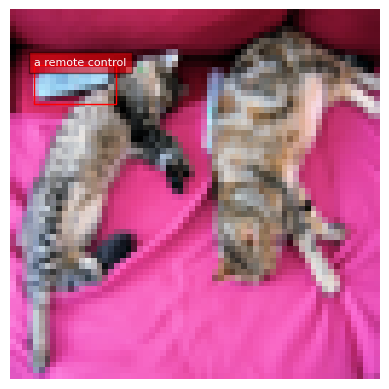

In [6]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Segmentation

In [17]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="a cat")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[36.57600021362305, 13.02400016784668, 37.02400207519531, 12.064000129699707, 37.7920036315918, 11.040000915527344, 38.560001373291016, 9.056000709533691, 40.03200149536133, 7.072000503540039, 41.56800079345703, 5.600000381469727, 42.52800369262695, 4.896000385284424, 44.000003814697266, 4.448000431060791, 45.53600311279297, 4.448000431060791, 47.07200241088867, 3.4240002632141113, 48.608001708984375, 3.4240002632141113, 50.08000183105469, 3.872000217437744, 51.10400390625, 4.448000431060791, 51.87200164794922, 4.896000385284424, 52.6400032043457, 5.600000381469727, 53.40800094604492, 6.368000507354736, 54.112003326416016, 6.368000507354736, 54.880001068115234, 7.072000503540039, 55.58400344848633, 7.072000503540039, 56.35200119018555, 7.648000240325928, 57.12000274658203, 8.35200023651123, 58.336002349853516, 8.35200023651123, 59.10400390625, 9.056000709533691, 59.87200164794922, 9.824000358581543, 60.6400032043457, 9.824000358581

In [ ]:
def calculate_polygon_area(polygon_points):
    """
    Calculate the area of a polygon using the Shoelace formula (also known as surveyor's formula).
    
    Args:
        polygon_points (list): List of [x, y] coordinates defining the polygon vertices
    
    Returns:
        float: Area of the polygon
    """
    n = len(polygon_points)
    area = 0.0
    
    for i in range(n):
        j = (i + 1) % n
        area += polygon_points[i][0] * polygon_points[j][1]
        area -= polygon_points[j][0] * polygon_points[i][1]
    
    area = abs(area) / 2.0
    return area

def get_segmentation_ratio(segmentation_results, image_width=640, image_height=480):
    """
    Calculate the ratio of segmented area to total image area.
    
    Args:
        segmentation_results (d ict): Dictionary containing segmentation polygons
        image_width (int): Width of the image (default 640 based on environment)
        image_height (int): Height of the image (default 480 based on environment)
    
    Returns:
        float: Ratio of segmented area to total image area
    """
    # Extract polygon points
    polygons = segmentation_results['<REFERRING_EXPRESSION_SEGMENTATION>']['polygons']
    
    # Calculate total segmented area (sum of all polygon areas)
    total_segmented_area = sum(calculate_polygon_area(polygon) for polygon in polygons)
    
    # Calculate total image area
    total_image_area = image_width * image_height
    
    # Calculate and return ratio
    ratio = round(total_segmented_area / total_image_area, 4)
    
    return ratio

# Example usage with your results
ratio = get_segmentation_ratio(results)
print(f"Segmentation area ratio: {ratio}")

In [ ]:
# Bounding box coordinates
x_min, y_min, x_max, y_max = results[0]['boxes'][0].tolist()
box_width = x_max - x_min
box_height = y_max - y_min
bounding_box_area = box_width * box_height

# Image dimensions and area
image_width, image_height = image.size
image_area = image_width * image_height

# Ratio of bounding box area to image area
area_ratio = round(bounding_box_area / image_area, 2)
area_ratio


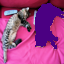

In [8]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)  

In [10]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image, ImageDraw 
import random
import numpy as np

# Initialize the model and processor
model_id = 'microsoft/Florence-2-base'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

def run_example(task_prompt, image, text_input=None):
    """Generates segmentation results based on the input image and task prompt."""
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

colormap = ['indigo']

def draw_polygons(image, prediction, fill_mask=False):  
    """Draws segmentation masks with polygons on an image and returns the modified image."""
    draw = ImageDraw.Draw(image)

    for polygons, label in zip(prediction['polygons'], prediction['labels']):  
        color = random.choice(colormap)  
        fill_color = random.choice(colormap) if fill_mask else None  
          
        for _polygon in polygons:  
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * 1).reshape(-1).tolist()  # Adjust for scale if needed
              
            # Draw the polygon  
            if fill_mask:  
                draw.polygon(_polygon, outline=color, fill=fill_color)  
            else:  
                draw.polygon(_polygon, outline=color)  
              
            # Draw the label text  
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)  
  
    return image  # Return the modified image

def segment_image(image_input: Image.Image, text_input="a cat") -> Image.Image:
    """Segments a given PIL Image based on the specified text input and returns the segmented image."""
    # Resize the image if necessary
    image = image_input.resize((64, 64))

    task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
    results = run_example(task_prompt, image, text_input=text_input)
    
    output_image = draw_polygons(image.copy(), results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)
    
    return output_image  # Return the segmented image

# Example usage
if __name__ == "__main__":
    # Load an image using PIL
    image_path = "path/to/your/image.jpg"  # Replace with your image path
    image = Image.open(image_path)
    
    # Get the segmented image
    segmented_image = segment_image(image, text_input="a cat")

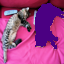

In [11]:
segmented_image

## Torchrl

In [1]:
import torch

print(torch.__version__)

2.4.1+cu121


In [ ]:
!pip install pyntcloud

In [10]:
# first time installs
!pip uninstall numpy -y
!pip install numpy==1.22.4
!pip install pandas
!pip install tqdm
!pip install tensordict-nightly
!pip install torchrl-nightly
!pip install torchvision

Found existing installation: numpy 1.22.4
Uninstalling numpy-1.22.4:
  Successfully uninstalled numpy-1.22.4
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.22.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [12]:
from collections import defaultdict
from typing import Optional


# import cv2 as cv
import numpy as np
# import pandas as pd
import torch
import tqdm
from tensordict import TensorDict, TensorDictBase
from tensordict.nn import TensorDictModule
from torch import nn
import torchvision
from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec
from torchrl.envs import (
    EnvBase,
    Transform,
    Compose,
    ToTensorImage,
    Resize,
    TransformedEnv,
    UnsqueezeTransform,
)

from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp


/home/ubuntu/.local/lib/python3.10/site-packages/torchrl/data/replay_buffers/samplers.py:37: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)


### Environment
#### `_step()`

- Read the input keys (such as "action") and execute the simulation based on these;
- Retrieve observations, done state and reward;
- Write the set of observation values along with the reward and done state at the corresponding entries in a new TensorDict.
- Merge the output TensorDict (as "next" key) in the input TensorDict.

In [9]:
import os
import glob

data_path = '/my_bot_v2/src/my_bot_controller/resource/24_10_19_sensorDump/'
image_path = 'egoCam/*.png'

image_files = glob.glob(data_path + image_path)
trajectory_data = pd.read_csv(data_path + 'trajectory.csv')


In [31]:
def _step(tensordict):
    
    # take a step
    step = tensordict["stepInt"].item()

    image = cv.imread(image_files[step])
    # height, width, channels = 480, 640, 3
    # image = np.zeros((height, width, channels), dtype=np.uint8)

    image_tensor = torch.tensor(image, dtype=torch.float32)

    step += 1

    step_tensor = torch.tensor(step, dtype=torch.int32)

    # laser_readings = ""
    # laser_tensor = torch.tensor(laser_readings, dtype=torch.float32)

    progress = torch.tensor(0, dtype=torch.float32)

    reward = progress.view(*tensordict.shape, 1)
    done = torch.zeros_like(reward, dtype=torch.bool)


    # write observations
    # merge the output with input tensordict
    out = TensorDict(
        {
            "stepInt": step_tensor,
            "image": image_tensor,
            # "laser": laser_tensor,
            "params": tensordict["params"],
            "reward": reward,
            "done": done,
        },
        tensordict.shape,
    )

    return out

#### _reset()

In [ ]:

# retrieve observations (observations, reward, done)


In [32]:
def _reset(self, tensordict):
    if tensordict is None or tensordict.is_empty():
        # if no ``tensordict`` is passed, we generate a single set of hyperparameters
        # Otherwise, we assume that the input ``tensordict`` contains all the relevant
        # parameters to get started.
        tensordict = self.gen_params(batch_size=self.batch_size)


    # retrieve observations (observations, reward, done)
    step = 0

    step_tensor = torch.tensor(step, dtype=torch.int32)
    # take a step
    image = cv.imread(image_files[step])

    # height, width, channels = 480, 640, 3
    # image = np.zeros((height, width, channels), dtype=np.uint8)
    
    image_tensor = torch.tensor(image, dtype=torch.float32)

    out = TensorDict(
        {   
            "stepInt": step_tensor,
            "image": image_tensor,
            "params": tensordict["params"],
        },
        batch_size=tensordict.shape,
    )
    return out

#### Environment metadata: `env.*_spec`

The specs define the input and output domain of the environment. They can also be used to instantiate lazily defined neural networks and test scripts. There are four specs that we must code in our environment:

- `EnvBase.observation_spec`: This will be a `CompositeSpec` instance where each key is an observation (a CompositeSpec can be viewed as a dictionary of specs).
- `EnvBase.action_spec`: It can be any type of spec, it corresponds to the "action" entry in the input tensordict;
- `EnvBase.reward_spec`: provides information about the reward space;
- `EnvBase.done_spec`: provides information about the space of the done flag.

TorchRL specs are organized in two general containers:
- input_spec which contains the specs of the information that the step function reads (divided between action_spec containing the action and state_spec containing all the rest),
- output_spec which encodes the specs that the step outputs (observation_spec, reward_spec and done_spec).

In general, you should not interact directly with output_spec and input_spec but only with their content: observation_spec, reward_spec, done_spec, action_spec and state_spec. TorchRL offers multiple TensorSpec subclasses to encode the environment’s input and output characteristics.

##### Specs shape
The environment specs leading dimensions must match the environment batch-size. This is done to enforce that every component of an environment (including its transforms) have an accurate representation of the expected input and output shapes. This is something that should be accurately coded in stateful settings. For non batch-locked environments, such as the one in our example (see below), this is irrelevant as the environment batch size will most likely be empty.

In [33]:
def _make_spec(self, td_params):
    # Under the hood, this will populate self.output_spec["observation"]
    self.observation_spec = CompositeSpec(
        stepInt=BoundedTensorSpec(
            low=td_params["params", "step_start"],
            high=td_params["params", "step_end"],
            shape=(),
            dtype=torch.int32,
        ),
        image=UnboundedContinuousTensorSpec(
            shape=(td_params["params", "imageHeight"], td_params["params", "imageWidth"], 3),
            dtype=torch.float32,
        ),
        # we need to add the ``params`` to the observation specs, as we want
        # to pass it at each step during a rollout
        params=make_composite_from_td(td_params["params"]),
        shape=(),
    )

    # action-spec will be automatically wrapped in input_spec when
    # `self.action_spec = spec` will be called supported
    self.action_spec = CompositeSpec(
        action=CompositeSpec(
            linear_velocity=BoundedTensorSpec(
                low=-td_params["params", "max_linear_velocity"],
                high=td_params["params", "max_linear_velocity"],
                shape=(),
                dtype=torch.float32,
            ),
            angular_velocity=BoundedTensorSpec(
                low=-td_params["params", "max_angular_velocity"],
                high=td_params["params", "max_angular_velocity"],
                shape=(),
                dtype=torch.float32,
            ),
            shape=(),
        ),
        shape=(),
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(*td_params.shape, 1))


def make_composite_from_td(td):
    # custom function to convert a ``tensordict`` in a similar spec structure
    # of unbounded values.
    composite = CompositeSpec(
        {
            key: make_composite_from_td(tensor)
            if isinstance(tensor, TensorDictBase)
            else UnboundedContinuousTensorSpec(
                dtype=tensor.dtype, device=tensor.device, shape=tensor.shape
            )
            for key, tensor in td.items()
        },
        shape=td.shape,
    )
    return composite

#### Seeding

In [34]:
def _set_seed(self, seed: Optional[int]):
    rng = torch.manual_seed(seed)
    self.rng = rng

#### Generate Parameters

In [35]:
def gen_params(batch_size=None) -> TensorDictBase:
    """Returns a ``tensordict`` containing the physical parameters such as gravitational force and torque or speed limits."""
    if batch_size is None:
        batch_size = []
    td = TensorDict(
        {
            "params": TensorDict(
                {
                    "step_start": 0,
                    "step_end": 20,
                    "max_linear_velocity": 1.0,
                    "max_angular_velocity": 1.0,
                    "imageHeight": 480,
                    "imageWidth": 640,
                },
                [],
            )
        },
        [],
    )
    if batch_size:
        td = td.expand(batch_size).contiguous()
    return td

#### Environment class

In [36]:
class my_botEnv(EnvBase):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }
    batch_locked = True

    def __init__(self, td_params=None, seed=None, device="cpu"):
        if td_params is None:
            td_params = self.gen_params()

        super().__init__(device=device, batch_size=[])
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    gen_params = staticmethod(gen_params)
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = staticmethod(_step)
    _set_seed = _set_seed

#### Check environment implementation

In [37]:
env = my_botEnv()
check_env_specs(env)

2024-10-26 04:39:43,602 [torchrl][INFO] check_env_specs succeeded!


In [98]:
print("observation_spec:", env.observation_spec)
print("state_spec:", env.state_spec)
print("reward_spec:", env.reward_spec)

observation_spec: CompositeSpec(
    stepInt: BoundedTensorSpec(
        shape=torch.Size([]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int32, contiguous=True),
            high=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int32, contiguous=True)),
        device=cpu,
        dtype=torch.int32,
        domain=continuous),
    image: UnboundedContinuousTensorSpec(
        shape=torch.Size([480, 640, 3]),
        space=None,
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    params: CompositeSpec(
        step_start: UnboundedContinuousTensorSpec(
            shape=torch.Size([]),
            space=None,
            device=cpu,
            dtype=torch.int64,
            domain=discrete),
        step_end: UnboundedContinuousTensorSpec(
            shape=torch.Size([]),
            space=None,
            device=cpu,
            dtype=torch.int64,
            domain=discrete),
        max_linear

In [77]:
td = env.reset()
print("reset tensordict", td)

reset tensordict TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        image: Tensor(shape=torch.Size([480, 640, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        params: TensorDict(
            fields={
                imageHeight: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                imageWidth: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                max_angular_velocity: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                max_linear_velocity: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                step_end: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                step_start: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([]),
            d

In [19]:
td = env.rand_step(td)
print("random step tensordict", td)

random step tensordict TensorDict(
    fields={
        action: TensorDict(
            fields={
                angular_velocity: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                linear_velocity: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        image: Tensor(shape=torch.Size([480, 640, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
                image: Tensor(shape=torch.Size([480, 640, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                params: TensorDict(
                    fields={
                        imageHeight: Tensor(shape=torch.Si

### Transforming environment

In [38]:
base_env = my_botEnv()
transform = Compose(ToTensorImage(in_keys=["image"]), Resize(64, 64, in_keys=["image"]))
env = TransformedEnv(base_env, transform)

In [100]:
check_env_specs(env)

2024-10-25 00:21:58,327 [torchrl][INFO] check_env_specs succeeded!


### Rollout

In [39]:
def simple_rollout(steps=15):
    # preallocate:
    data = TensorDict({}, [steps])
    # reset
    _data = env.reset()
    for i in range(steps):
        _data["action"] = env.action_spec.rand()
        _data = env.step(_data)
        data[i] = _data
        _data = step_mdp(_data, keep_other=True)
    return data


print("data from rollout:", simple_rollout(15))

data from rollout: TensorDict(
    fields={
        action: TensorDict(
            fields={
                action: TensorDict(
                    fields={
                        angular_velocity: Tensor(shape=torch.Size([15]), device=cpu, dtype=torch.float32, is_shared=False),
                        linear_velocity: Tensor(shape=torch.Size([15]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([15]),
                    device=cpu,
                    is_shared=False)},
            batch_size=torch.Size([15]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([15, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        image: Tensor(shape=torch.Size([15, 3, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([15, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                image: T

### Batching

In [40]:
batch_size = 1 # number of environments to be executed in batch
td = env.reset(env.gen_params(batch_size=[batch_size]))
print(f"reset (batch size of {batch_size})", td)
td = env.rand_step(td)
print(f"rand step (batch size of {batch_size})", td)

RuntimeError: Expected a tensordict with shape==env.batch_size, got torch.Size([1]) and torch.Size([])

### Training a Simple Policy

In [23]:
torch.manual_seed(0)
env.set_seed(0)

net = nn.Sequential(
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(1),
)
policy = TensorDictModule(
    net,
    in_keys=["observation"],
    out_keys=["action"],
)

optim = torch.optim.Adam(policy.parameters(), lr=2e-3)

#### Training loop
We will successively:

- generate a trajectory
- sum the rewards
- backpropagate through the graph defined by these operations
- clip the gradient norm and make an optimization step
- repeat

At the end of the training loop, we should have a final reward close to 0 which demonstrates that the pendulum is upward and still as desired.



In [ ]:
batch_size = 1
pbar = tqdm.tqdm(range(20_000 // batch_size))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 20_000)
logs = defaultdict(list)

for _ in pbar:
    init_td = env.reset(env.gen_params(batch_size=[batch_size]))
    rollout = env.rollout(100, policy, tensordict=init_td, auto_reset=False)
    traj_return = rollout["next", "reward"].mean()
    (-traj_return).backward()
    gn = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    optim.step()
    optim.zero_grad()
    pbar.set_description(
        f"reward: {traj_return: 4.4f}, "
        f"last reward: {rollout[..., -1]['next', 'reward'].mean(): 4.4f}, gradient norm: {gn: 4.4}"
    )
    logs["return"].append(traj_return.item())
    logs["last_reward"].append(rollout[..., -1]["next", "reward"].mean().item())
    scheduler.step()


def plot():
    import matplotlib
    from matplotlib import pyplot as plt

    is_ipython = "inline" in matplotlib.get_backend()
    if is_ipython:
        from IPython import display

    with plt.ion():
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(logs["return"])
        plt.title("returns")
        plt.xlabel("iteration")
        plt.subplot(1, 2, 2)
        plt.plot(logs["last_reward"])
        plt.title("last reward")
        plt.xlabel("iteration")
        if is_ipython:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        plt.show()


plot()

### Troubleshoot

In [41]:
def _step(tensordict):
    # take a step
    step = tensordict["stepInt"].item()  # Can use .item() since we're guaranteed single instance
    
    # Create single image
    image = cv.imread(image_files[step])
    image_tensor = torch.tensor(image, dtype=torch.float32)

    step += 1
    step_tensor = torch.tensor(step, dtype=torch.int32)

    progress = torch.tensor(0, dtype=torch.float32)
    reward = progress.view(1)  # Single reward
    done = torch.zeros_like(reward, dtype=torch.bool)

    # Create TensorDict without explicit shape argument
    out = TensorDict(
        {
            "stepInt": step_tensor,
            "image": image_tensor,
            "params": tensordict["params"],
            "reward": reward,
            "done": done,
        },
        batch_size=[],  # Use batch_size instead of shape
    )

    return out


In [42]:
def _reset(self, tensordict):
    if tensordict is None or tensordict.is_empty():
        # if no ``tensordict`` is passed, we generate a single set of hyperparameters
        # Otherwise, we assume that the input ``tensordict`` contains all the relevant
        # parameters to get started.
        tensordict = self.gen_params(batch_size=self.batch_size)


    # retrieve observations (observations, reward, done)
    step = 0

    step_tensor = torch.tensor(step, dtype=torch.int32)
    # take a step
    # image = cv.imread(image_files[step])

    image = cv.imread(image_files[step])
    
    image_tensor = torch.tensor(image, dtype=torch.float32)

    out = TensorDict(
        {   
            "stepInt": step_tensor,
            "image": image_tensor,
            "params": tensordict["params"],
        },
        batch_size=tensordict.shape,
    )
    return out

In [43]:
def _set_seed(self, seed: Optional[int]):
    rng = torch.manual_seed(seed)
    self.rng = rng

In [44]:
def _make_spec(self, td_params):
    self.observation_spec = CompositeSpec(
        stepInt=BoundedTensorSpec(
            low=td_params["params", "step_start"],
            high=td_params["params", "step_end"],
            shape=(),  # Single instance, no batch dimension
            dtype=torch.int32,
        ),
        image=UnboundedContinuousTensorSpec(
            shape=(td_params["params", "imageHeight"], 
                  td_params["params", "imageWidth"], 3),  # Single image shape
            dtype=torch.float32,
        ),
        params=make_composite_from_td(td_params["params"]),
        shape=(),  # Single instance
    )

    self.action_spec = CompositeSpec(
        action=CompositeSpec(
            linear_velocity=BoundedTensorSpec(
                low=-td_params["params", "max_linear_velocity"],
                high=td_params["params", "max_linear_velocity"],
                shape=(),  # Single instance
                dtype=torch.float32,
            ),
            angular_velocity=BoundedTensorSpec(
                low=-td_params["params", "max_angular_velocity"],
                high=td_params["params", "max_angular_velocity"],
                shape=(),  # Single instance
                dtype=torch.float32,
            ),
            shape=(),
        ),
        shape=(),
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(1,))


In [45]:
def gen_params(*args, **kwargs) -> TensorDictBase:
    """Returns a tensordict containing the parameters. Ignores any arguments since we're batch_locked."""
    td = TensorDict(
        {
            "params": TensorDict(
                {
                    "step_start": 0,
                    "step_end": 20,
                    "max_linear_velocity": 1.0,
                    "max_angular_velocity": 1.0,
                    "imageHeight": 480,
                    "imageWidth": 640,
                },
                batch_size=[],
            )
        },
        batch_size=[],
    )
    return td

class my_botEnv(EnvBase):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }
    batch_locked = True  # Lock to single instance since we're using Gazebo

    def __init__(self, td_params=None, seed=None, device="cpu"):
        if td_params is None:
            td_params = self.gen_params()

        super().__init__(device=device, batch_size=[])
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    gen_params = staticmethod(gen_params)
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = staticmethod(_step)
    _set_seed = _set_seed

In [46]:
env = my_botEnv()
check_env_specs(env)

2024-10-26 04:46:03,933 [torchrl][INFO] check_env_specs succeeded!


In [47]:
print("observation_spec:", env.observation_spec)
print("state_spec:", env.state_spec)
print("reward_spec:", env.reward_spec)

observation_spec: Composite(
    stepInt: BoundedDiscrete(
        shape=torch.Size([]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int32, contiguous=True),
            high=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int32, contiguous=True)),
        device=cpu,
        dtype=torch.int32,
        domain=discrete),
    image: UnboundedContinuous(
        shape=torch.Size([480, 640, 3]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([480, 640, 3]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([480, 640, 3]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    params: Composite(
        step_start: UnboundedDiscrete(
            shape=torch.Size([]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, contiguous=True

In [48]:
td = env.reset()
print("reset tensordict", td)

reset tensordict TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        image: Tensor(shape=torch.Size([480, 640, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        params: TensorDict(
            fields={
                imageHeight: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                imageWidth: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                max_angular_velocity: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                max_linear_velocity: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                step_end: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                step_start: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([]),
            d

In [49]:
td = env.rand_step(td)
print("random step tensordict", td)

random step tensordict TensorDict(
    fields={
        action: TensorDict(
            fields={
                angular_velocity: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                linear_velocity: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        image: Tensor(shape=torch.Size([480, 640, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
                image: Tensor(shape=torch.Size([480, 640, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                params: TensorDict(
                    fields={
                        imageHeight: Tensor(shape=torch.Si

### Transforming environment

In [50]:
base_env = my_botEnv()
transform = Compose(ToTensorImage(in_keys=["image"]), Resize(64, 64, in_keys=["image"]))
env = TransformedEnv(base_env, transform)

In [51]:
check_env_specs(env)

2024-10-26 04:46:18,553 [torchrl][INFO] check_env_specs succeeded!


### Rollout

In [52]:
def simple_rollout(steps=15):
    # preallocate:
    data = TensorDict({}, [steps])
    # reset
    _data = env.reset()
    for i in range(steps):
        _data["action"] = env.action_spec.rand()
        _data = env.step(_data)
        data[i] = _data
        _data = step_mdp(_data, keep_other=True)
    return data


print("data from rollout:", simple_rollout(15))

data from rollout: TensorDict(
    fields={
        action: TensorDict(
            fields={
                action: TensorDict(
                    fields={
                        angular_velocity: Tensor(shape=torch.Size([15]), device=cpu, dtype=torch.float32, is_shared=False),
                        linear_velocity: Tensor(shape=torch.Size([15]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([15]),
                    device=cpu,
                    is_shared=False)},
            batch_size=torch.Size([15]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([15, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        image: Tensor(shape=torch.Size([15, 3, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([15, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                image: T

### Batching

In [53]:
batch_size = 1 # number of environments to be executed in batch
td = env.reset(env.gen_params(batch_size=[batch_size]))
print(f"reset (batch size of {batch_size})", td)
td = env.rand_step(td)
print(f"rand step (batch size of {batch_size})", td)

reset (batch size of 1) TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        image: Tensor(shape=torch.Size([3, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
        params: TensorDict(
            fields={
                imageHeight: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                imageWidth: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                max_angular_velocity: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                max_linear_velocity: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                step_end: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
                step_start: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([]),
        

### Training a Simple Policy

In [54]:
torch.manual_seed(0)
env.set_seed(0)

net = nn.Sequential(
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(64),
    nn.Tanh(),
    nn.LazyLinear(1),
)
policy = TensorDictModule(
    net,
    in_keys=["observation"],
    out_keys=["action"],
)

optim = torch.optim.Adam(policy.parameters(), lr=2e-3)

#### Training loop
We will successively:

- generate a trajectory
- sum the rewards
- backpropagate through the graph defined by these operations
- clip the gradient norm and make an optimization step
- repeat

At the end of the training loop, we should have a final reward close to 0 which demonstrates that the pendulum is upward and still as desired.



In [58]:
batch_size = 1
pbar = tqdm.tqdm(range(4 // batch_size))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 4)
logs = defaultdict(list)

for _ in pbar:
    init_td = env.reset(env.gen_params(batch_size=[batch_size]))
    rollout = env.rollout(4, policy, tensordict=init_td, auto_reset=False)
    traj_return = rollout["next", "reward"].mean()
    (-traj_return).backward()
    gn = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    optim.step()
    optim.zero_grad()
    pbar.set_description(
        f"reward: {traj_return: 4.4f}, "
        f"last reward: {rollout[..., -1]['next', 'reward'].mean(): 4.4f}, gradient norm: {gn: 4.4}"
    )
    logs["return"].append(traj_return.item())
    logs["last_reward"].append(rollout[..., -1]["next", "reward"].mean().item())
    scheduler.step()


def plot():
    import matplotlib
    from matplotlib import pyplot as plt

    is_ipython = "inline" in matplotlib.get_backend()
    if is_ipython:
        from IPython import display

    with plt.ion():
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(logs["return"])
        plt.title("returns")
        plt.xlabel("iteration")
        plt.subplot(1, 2, 2)
        plt.plot(logs["last_reward"])
        plt.title("last reward")
        plt.xlabel("iteration")
        if is_ipython:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        plt.show()


plot()

  0%|          | 0/4 [00:00<?, ?it/s]


KeyError: "Some tensors that are necessary for the module call may not have not been found in the input tensordict: the following inputs are None: {'observation'}."

### Troubleshott 2

In [21]:
def make_composite_from_td(td):
    # custom function to convert a ``tensordict`` in a similar spec structure
    # of unbounded values.
    composite = CompositeSpec(
        {
            key: make_composite_from_td(tensor)
            if isinstance(tensor, TensorDictBase)
            else UnboundedContinuousTensorSpec(
                dtype=tensor.dtype, device=tensor.device, shape=tensor.shape
            )
            for key, tensor in td.items()
        },
        shape=td.shape,
    )
    return composite

In [22]:
def gen_params(batch_size=None, *args, **kwargs) -> TensorDictBase:
    """Returns a tensordict containing the parameters with specified batch size."""
    if batch_size is None:
        batch_size = [1]
        
    td = TensorDict(
        {
            "params": TensorDict(
                {
                    "step_start": torch.zeros(batch_size, dtype=torch.int32),
                    "step_end": torch.full(batch_size, 20, dtype=torch.int32),
                    "max_linear_velocity": torch.ones(batch_size, dtype=torch.float32),
                    "max_angular_velocity": torch.ones(batch_size, dtype=torch.float32),
                    "imageHeight": torch.full(batch_size, 480, dtype=torch.int32),
                    "imageWidth": torch.full(batch_size, 640, dtype=torch.int32),
                },
                batch_size=batch_size,
            )
        },
        batch_size=batch_size,
    )
    return td

def _step(tensordict):
    # Take a step
    step = tensordict["stepInt"]
    batch_size = step.shape[0]
    
    # Create image with proper batch dimension
    height, width, channels = 480, 640, 3
    image = np.zeros((batch_size, height, width, channels), dtype=np.uint8)
    image_tensor = torch.tensor(image, dtype=torch.float32)

    # Ensure step increment maintains batch dimension
    step = step + torch.ones_like(step)

    # Initialize tensors with proper batch dimension
    progress = torch.zeros((batch_size, 1), dtype=torch.float32)
    reward = progress.clone()
    done = torch.zeros((batch_size, 1), dtype=torch.bool)

    out = TensorDict(
        {
            "stepInt": step,
            "image": image_tensor,
            "params": tensordict["params"],
            "reward": reward,
            "done": done,
        },
        batch_size=[batch_size],
    )

    return out

def _make_spec(self, td_params):
    batch_size = td_params.batch_size

    self.observation_spec = CompositeSpec(
        stepInt=BoundedTensorSpec(
            low=td_params["params", "step_start"],
            high=td_params["params", "step_end"],
            shape=batch_size,
            dtype=torch.int32,
        ),
        image=UnboundedContinuousTensorSpec(
            shape=(batch_size[0], td_params["params", "imageHeight"][0].item(), 
                  td_params["params", "imageWidth"][0].item(), 3),
            dtype=torch.float32,
        ),
        params=make_composite_from_td(td_params["params"]),
        shape=batch_size,
    )

    self.action_spec = CompositeSpec(
        action=CompositeSpec(
            linear_velocity=BoundedTensorSpec(
                low=-td_params["params", "max_linear_velocity"],
                high=td_params["params", "max_linear_velocity"],
                shape=batch_size,
                dtype=torch.float32,
            ),
            angular_velocity=BoundedTensorSpec(
                low=-td_params["params", "max_angular_velocity"],
                high=td_params["params", "max_angular_velocity"],
                shape=batch_size,
                dtype=torch.float32,
            ),
            shape=batch_size,
        ),
        shape=batch_size,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(batch_size[0], 1))

def _reset(self, td_params=None):
    if td_params is None:
        td_params = self.gen_params()
    
    batch_size = td_params.batch_size
    
    return TensorDict({
        "stepInt": torch.zeros(batch_size, dtype=torch.int32),
        "image": torch.zeros((batch_size[0],
                            td_params["params", "imageHeight"][0].item(), 
                            td_params["params", "imageWidth"][0].item(), 3), 
                           dtype=torch.float32),
        "params": td_params["params"]
    }, batch_size=batch_size)

class my_botEnv(EnvBase):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }
    batch_locked = False

    def __init__(self, td_params=None, seed=None, device="cpu", batch_size=None):
        if batch_size is None:
            batch_size = [1]
            
        if td_params is None:
            td_params = self.gen_params(batch_size=batch_size)

        super().__init__(device=device, batch_size=batch_size)
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    def _set_seed(self, seed: Optional[int]):
        rng = torch.manual_seed(seed)
        self.rng = rng

    gen_params = staticmethod(gen_params)
    _make_spec = _make_spec
    _reset = _reset
    _step = staticmethod(_step)

In [23]:
env = my_botEnv()
check_env_specs(env)

/home/ubuntu/.local/lib/python3.10/site-packages/torchrl/data/tensor_specs.py:5464: DeprecationWarning: The CompositeSpec has been deprecated and will be removed in v0.7. Please use Composite instead.
  warnings.warn(
2024-10-26 21:45:16,604 [torchrl][INFO] check_env_specs succeeded!


In [15]:
print("observation_spec:", env.observation_spec)
print("state_spec:", env.state_spec)
print("reward_spec:", env.reward_spec)

observation_spec: Composite(
    stepInt: BoundedDiscrete(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int32, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int32, contiguous=True)),
        device=cpu,
        dtype=torch.int32,
        domain=discrete),
    image: UnboundedContinuous(
        shape=torch.Size([1, 480, 640, 3]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1, 480, 640, 3]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([1, 480, 640, 3]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    params: Composite(
        step_start: UnboundedDiscrete(
            shape=torch.Size([1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int32, c

In [16]:
td = env.reset()
print("reset tensordict", td)

reset tensordict TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        image: Tensor(shape=torch.Size([1, 480, 640, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        params: TensorDict(
            fields={
                imageHeight: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int32, is_shared=False),
                imageWidth: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int32, is_shared=False),
                max_angular_velocity: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                max_linear_velocity: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_end: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int32, is_shared=False),
                step_start: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int32, is_shared=False)},
            batch_size=torch.Size([1]),


In [17]:
td = env.rand_step(td)
print("random step tensordict", td)

random step tensordict TensorDict(
    fields={
        action: TensorDict(
            fields={
                angular_velocity: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                linear_velocity: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([1]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        image: Tensor(shape=torch.Size([1, 480, 640, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                image: Tensor(shape=torch.Size([1, 480, 640, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                params: TensorDict(
                    fields={
                        imageHeight: Tensor

### Transforming environment

In [26]:
base_env = my_botEnv()
transform = Compose(ToTensorImage(in_keys=["image"]), Resize(64, 64, in_keys=["image"]))
env = TransformedEnv(base_env, transform)

In [27]:
check_env_specs(env)

2024-10-26 04:37:00,270 [torchrl][INFO] check_env_specs succeeded!


### Rollout

In [28]:
def simple_rollout(steps=15):
    # preallocate:
    data = TensorDict({}, [steps])
    # reset
    _data = env.reset()
    for i in range(steps):
        _data["action"] = env.action_spec.rand()
        _data = env.step(_data)
        data[i] = _data
        _data = step_mdp(_data, keep_other=True)
    return data


print("data from rollout:", simple_rollout(15))

data from rollout: TensorDict(
    fields={
        action: TensorDict(
            fields={
                action: TensorDict(
                    fields={
                        angular_velocity: Tensor(shape=torch.Size([15, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        linear_velocity: Tensor(shape=torch.Size([15, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([15, 1]),
                    device=cpu,
                    is_shared=False)},
            batch_size=torch.Size([15, 1]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([15, 1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        image: Tensor(shape=torch.Size([15, 1, 3, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([15, 1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
   

### Batching

In [ ]:
batch_size = 1 # number of environments to be executed in batch
td = env.reset(env.gen_params(batch_size=[batch_size]))
print(f"reset (batch size of {batch_size})", td)
td = env.rand_step(td)
print(f"rand step (batch size of {batch_size})", td)

## RL Function

In [ ]:
import torch
import numpy as np
from tensordict import TensorDict, TensorDictBase
from torchrl.envs import EnvBase
from torchrl.envs.utils import check_env_specs
from torchrl.data import CompositeSpec, BoundedTensorSpec, UnboundedContinuousTensorSpec
import torch.nn as nn

class ImageBasedRLAgent:
    def __init__(self, batch_size=None, device="cpu", seed=None):
        """
        Initialize the RL agent with the environment and policy network.
        
        Args:
            batch_size (list): Batch size for processing, defaults to [1]
            device (str): Device to run computations on
            seed (int): Random seed for reproducibility
        """
        self.device = device
        self.batch_size = [1] if batch_size is None else batch_size
        
        # Initialize the environment
        self.env = my_botEnv(batch_size=self.batch_size, device=self.device, seed=seed)
        
        # Initialize the policy network
        self.policy_net = PolicyNetwork().to(device)
        
    def preprocess_image(self, image):
        """
        Preprocess the input image for the policy network.
        
        Args:
            image (torch.Tensor): Input image tensor of shape (B, H, W, C)
            
        Returns:
            torch.Tensor: Preprocessed image tensor
        """
        # Normalize pixel values to [0, 1]
        image = image.float() / 255.0
        
        # Permute dimensions from (B, H, W, C) to (B, C, H, W)
        image = image.permute(0, 3, 1, 2)
        
        return image.to(self.device)
    
    def select_action(self, image, step_count):
        """
        Select an action based on the current observation.
        
        Args:
            image (torch.Tensor): Current observation image
            step_count (torch.Tensor): Current step count
            
        Returns:
            TensorDict: Selected action in the required format
        """
        # Preprocess image
        processed_image = self.preprocess_image(image)
        
        # Get policy network predictions
        with torch.no_grad():
            linear_vel, angular_vel = self.policy_net(processed_image)
        
        # Create action TensorDict
        action_dict = TensorDict({
            "action": TensorDict({
                "linear_velocity": linear_vel,
                "angular_velocity": angular_vel
            }, batch_size=self.batch_size)
        }, batch_size=self.batch_size)
        
        return action_dict
    
    def update_policy(self, reward):
        """
        Update the policy based on the received reward.
        This is a placeholder for implementing actual policy updates.
        
        Args:
            reward (torch.Tensor): Reward received from the environment
        """
        # Implement your policy update logic here
        pass


class PolicyNetwork(nn.Module):
    """
    Neural network for processing images and outputting actions.
    """
    def __init__(self):
        super().__init__()
        
        # CNN layers for processing images
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        # Fully connected layers for action output
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 53 * 73, 512),  # Adjusted for 480x640 input
            nn.ReLU(),
            nn.Linear(512, 2)  # 2 outputs: linear and angular velocity
        )
        
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input image tensor of shape (B, C, H, W)
            
        Returns:
            tuple: (linear_velocity, angular_velocity) tensors
        """
        x = self.conv_layers(x)
        x = x.reshape(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        
        # Split output into linear and angular velocity
        linear_velocity = x[:, 0].unsqueeze(-1)
        angular_velocity = x[:, 1].unsqueeze(-1)
        
        return linear_velocity, angular_velocity

# Example usage
def main():
    # Initialize the agent
    agent = ImageBasedRLAgent()
    
    # Reset the environment
    tensordict = agent.env.reset()
    
    # Run a few steps
    for _ in range(5):
        # Get the current image and step count
        current_image = tensordict["image"]
        step_count = tensordict["stepInt"]
        
        # Select action
        action = agent.select_action(current_image, step_count)
        
        # Take a step in the environment
        tensordict = agent.env.step(action)
        
        # Update policy (if implementing learning)
        if "reward" in tensordict:
            agent.update_policy(tensordict["reward"])

if __name__ == "__main__":
    main()